<a href="https://colab.research.google.com/github/bayjan/notebooks/blob/master/testR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
installed.packages()

In [0]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_3.6.3  IRdisplay_0.7.0 pbdZMQ_0.3-3    tools_3.6.3    
 [5] htmltools_0.4.0 pillar_1.4.4    base64enc_0.1-3 crayon_1.3.4   
 [9] Rcpp_1.0.4.6    uuid_0.1-4      vctrs_0.3.0     IRkernel_1.1   
[13] jsonlite_1.6.1  digest_0.6.25   repr_1.1

In [0]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
BiocManager::install("limma")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'BiocVersion', 'limma'

Old packages: 'backports', 'curl', 'ellipsis', 'farver', 'glue', 'haven',
  'modelr', 'processx', 'rex', 'rprojroot', 'rversions', 'systemfonts',
  'tidyr', 'tinytex', 'xfun', 'nlme'



In [0]:
library(limma)

In [0]:
BiocManager::install("Biobase")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'Biobase'

also installing the dependency ‘BiocGenerics’


Old packages: 'backports', 'curl', 'ellipsis', 'farver', 'glue', 'haven',
  'modelr', 'processx', 'rex', 'rprojroot', 'rversions', 'systemfonts',
  'tidyr', 'tinytex', 'xfun', 'nlme'



In [0]:
BiocManager::install("GEOquery")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'GEOquery'

Old packages: 'backports', 'curl', 'ellipsis', 'farver', 'glue', 'haven',
  'modelr', 'processx', 'rex', 'rprojroot', 'rversions', 'systemfonts',
  'tidyr', 'tinytex', 'xfun', 'nlme'



In [0]:
# Version info: R 3.2.3, Biobase 2.30.0, GEOquery 2.40.0, limma 3.26.8
# R scripts generated  Tue May 26 09:01:30 EDT 2020

################################################################
#   Differential expression analysis with limma
library(Biobase)
library(GEOquery)
library(limma)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes co

In [0]:
# load series and platform data from GEO

gset <- getGEO("GSE77627", GSEMatrix =TRUE, AnnotGPL=FALSE)
if (length(gset) > 1) idx <- grep("GPL14951", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

Found 1 file(s)

GSE77627_series_matrix.txt.gz

Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)

See spec(...) for full column specifications.

File stored at: 

/tmp/Rtmp71qc2j/GPL14951.soft



In [0]:
dim(gset)

Features  Samples 
   29377       54

In [0]:
# group names for all samples
gsms <- "000000000000001111111111111111112222222222222222222222"
sml <- c()
for (i in 1:nchar(gsms)) { sml[i] <- substr(gsms,i,i) }

# log2 transform
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0) ||
          (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

# set up the data and proceed with analysis
sml <- paste("G", sml, sep="")    # set group names
fl <- as.factor(sml)
gset$description <- fl
design <- model.matrix(~ description + 0, gset)
colnames(design) <- levels(fl)
fit <- lmFit(gset, design)
cont.matrix <- makeContrasts(G2-G0, G1-G0, G2-G1, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)

tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","F","GI","SEQUENCE","GB_ACC"))

In [0]:
dim(ex)

[1] 29377    54

In [0]:
head(ex)

,GSM2055372,GSM2055373,GSM2055374,GSM2055375,GSM2055376,GSM2055377,GSM2055378,GSM2055379,GSM2055380,GSM2055381,⋯,GSM2055416,GSM2055417,GSM2055418,GSM2055419,GSM2055420,GSM2055421,GSM2055422,GSM2055423,GSM2055424,GSM2055425
ILMN_1343291,11.113310,10.911498,10.099644,11.620016,11.010716,12.381947,11.622448,11.414373,11.621094,11.254588,⋯,10.560482,6.768439,8.629461,9.511059,10.041523,8.218652,9.564976,7.741841,8.159798,10.460650
ILMN_1651209,5.498424,5.685729,5.604802,5.128122,6.061489,6.460587,4.999437,5.393922,5.430703,5.483006,⋯,4.868157,4.942206,4.684527,5.128544,3.481196,5.229384,4.770085,4.649537,5.096685,5.252822
ILMN_1651228,13.108266,13.667156,13.603567,13.177546,13.744375,13.405251,12.859139,12.618365,12.824790,13.336363,⋯,10.855236,10.555975,11.701391,13.187368,11.484852,11.375379,11.039610,10.082333,5.511782,11.273828
ILMN_1651229,7.693703,7.900606,7.343670,7.761039,9.318031,5.841266,8.708758,8.136221,7.221671,8.966712,⋯,9.850331,8.944084,9.234915,9.400414,10.104685,9.420219,9.962681,9.086148,8.599612,9.060725
ILMN_1651235,4.376876,4.884843,4.871146,9.247517,5.333152,4.904845,4.372815,4.211306,4.736234,6.002259,⋯,6.194226,7.430557,6.175878,6.419317,4.762720,5.358813,6.742267,4.947798,7.887925,9.007747
ILMN_1651236,6.082307,6.010409,6.113261,5.961114,6.474082,7.138446,6.175706,5.269149,5.257112,5.502122,⋯,6.409919,8.143461,8.348656,5.795832,7.034074,8.984457,8.985722,8.219995,7.968541,7.225529


In [0]:
ex.pca <- princomp(ex)

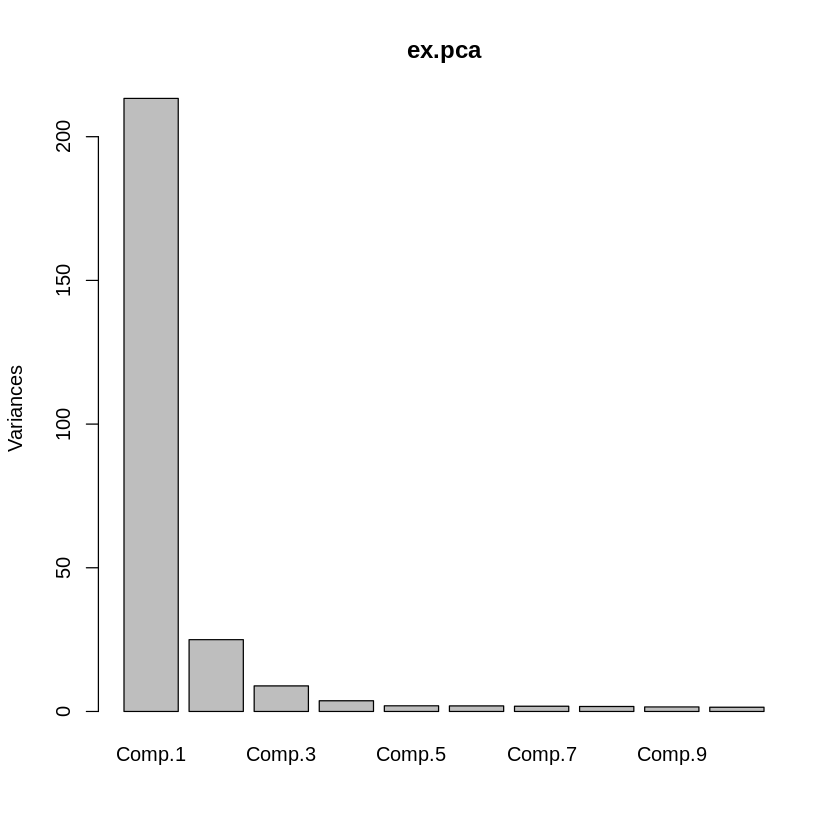

In [0]:
plot(ex.pca)

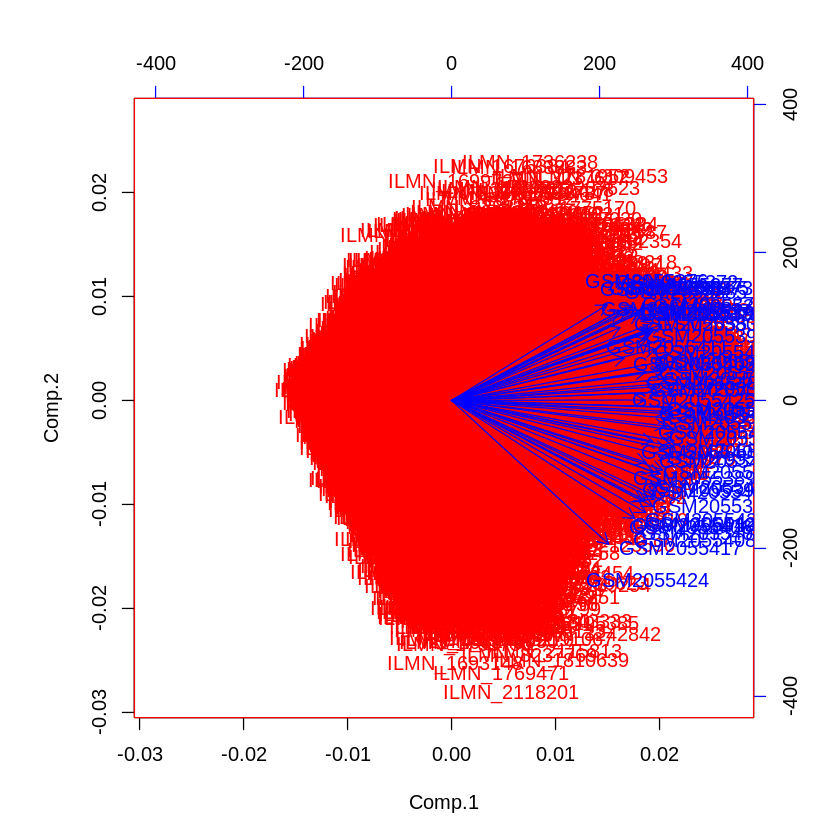

In [0]:
biplot(ex.pca,col=c("red","blue","black"))

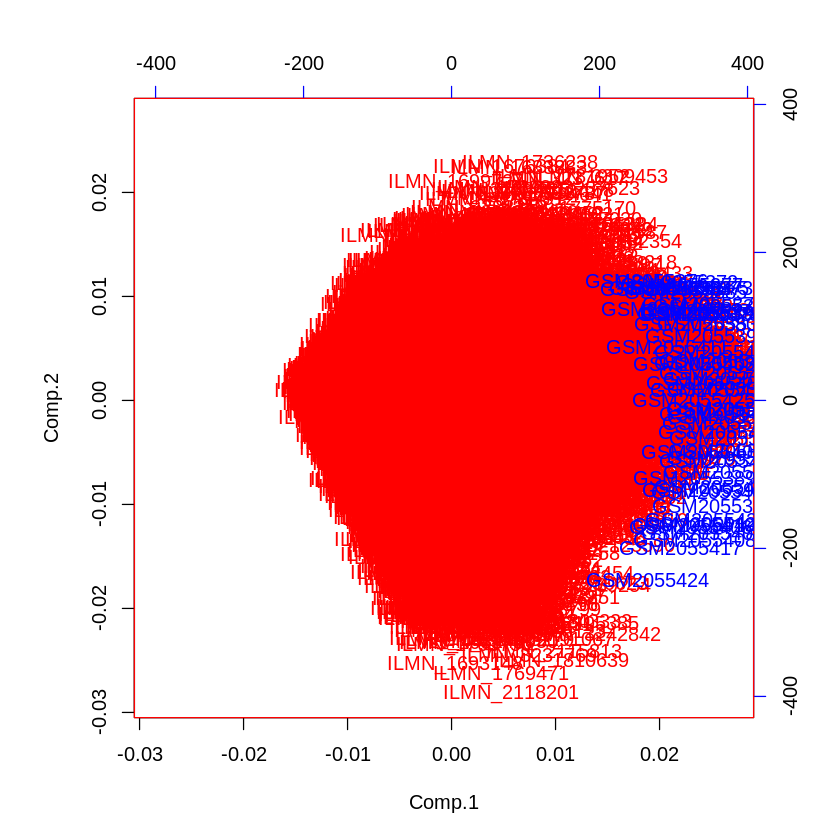

In [0]:
biplot(ex.pca,col=c("red","blue","black"),var.axes = FALSE,pch=".")

In [0]:
ex.pca1 <- prcomp(ex)

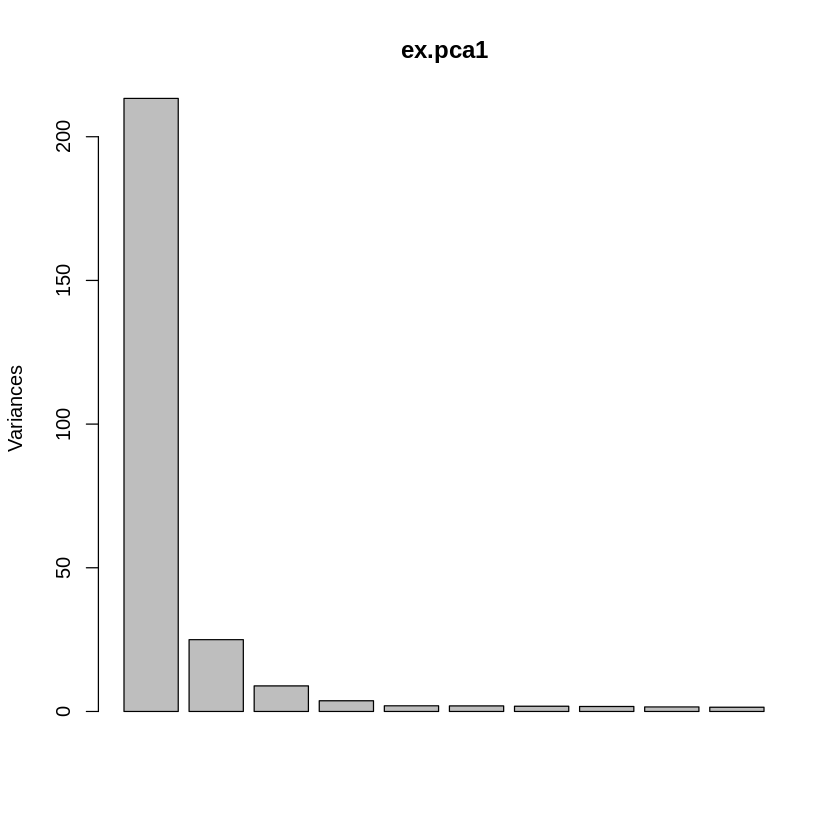

In [0]:
plot(ex.pca1)

In [0]:
ex.dist <- dist(ex) # euclidean distances between the rows

ERROR: ignored

In [0]:
ex.dfit <- cmdscale(ex.dist,eig=TRUE, k=2) # k is the number of dim

ERROR: ignored

In [0]:
ex.pca$

[1] 29377

In [0]:
head(tT)

,ID,adj.P.Val,P.Value,F,GI,SEQUENCE,GB_ACC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ILMN_3310623,ILMN_3310623,5.392065e-26,1.835472e-30,297.3513,262205268,TGTTGGATTCGGGGCCGTAGCACTGTCTGAGAGGTTTACATTTCTCACAG,NR_029672.1
ILMN_3237439,ILMN_3237439,7.503239e-25,5.108241e-29,260.7608,84872019,TTGATCGTCTGACATGATAATGTATTTTTGTCCTCTAAGAAGTTCTGAGC,NR_002735.1
ILMN_3242908,ILMN_3242908,1.521481e-24,1.553747e-28,249.4661,112734811,AACAGGAGCACCTCAGTGCAAGGACGACTCTTATCTATCACCCATGACTG,NR_003140.1
ILMN_3235397,ILMN_3235397,4.209814e-24,5.732122e-28,236.7741,98162773,TCTGTCAATCCCCTGAGTGCAATCACTGATGTCTCCATGTCTCTGAGCAA,NR_003078.1
ILMN_3242525,ILMN_3242525,4.411160e-24,7.507846e-28,234.2236,84872039,GGTCAATGATGTGTTGGCATGTATTATCTGAATCTATTGCTGATGTGTAA,NR_002749.1
ILMN_3247148,ILMN_3247148,6.062840e-24,1.238283e-27,229.5597,157738635,TTGAGTGCTAGAATGATGAGGATCTTAACCACCATTATCTTAACTGAGGC,NR_003942.1


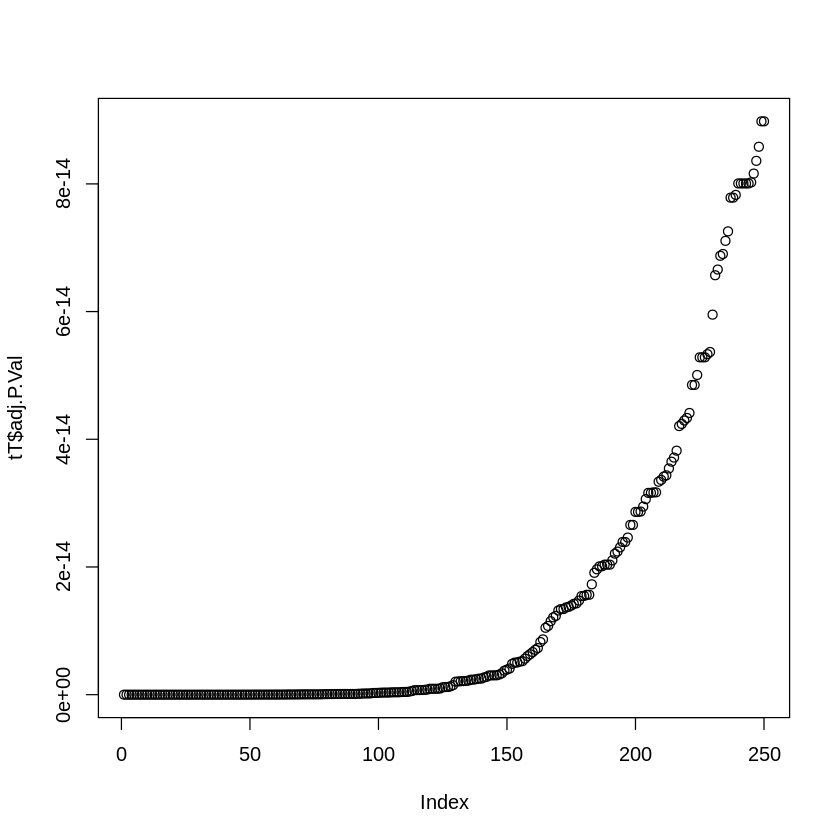

In [0]:
plot(tT$adj.P.Val)

In [0]:
################################################################
#   Boxplot for selected GEO samples
library(Biobase)
library(GEOquery)

# load series and platform data from GEO

gset <- getGEO("GSE77627", GSEMatrix =TRUE, getGPL=FALSE)
if (length(gset) > 1) idx <- grep("GPL14951", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# group names for all samples in a series
gsms <- "000000000000001111111111111111112222222222222222222222"
sml <- c()
for (i in 1:nchar(gsms)) { sml[i] <- substr(gsms,i,i) }
sml <- paste("G", sml, sep="")  # set group names

# order samples by group
ex <- exprs(gset)[ , order(sml)]
sml <- sml[order(sml)]
fl <- as.factor(sml)
labels <- c("HNL","INCPH","LC")

# set parameters and draw the plot
palette(c("#dfeaf4","#f4dfdf","#dfeaf4", "#AABBCC"))
dev.new(width=4+dim(gset)[[2]]/5, height=6)
par(mar=c(2+round(max(nchar(sampleNames(gset)))/2),4,2,1))
title <- paste ("GSE77627", '/', annotation(gset), " selected samples", sep ='')
boxplot(ex, boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=fl)
legend("topleft", labels, fill=palette(), bty="n")
dev.off()

Found 1 file(s)

GSE77627_series_matrix.txt.gz

Using locally cached version: /tmp/Rtmp71qc2j/GSE77627_series_matrix.txt.gz

Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)

See spec(...) for full column specifications.



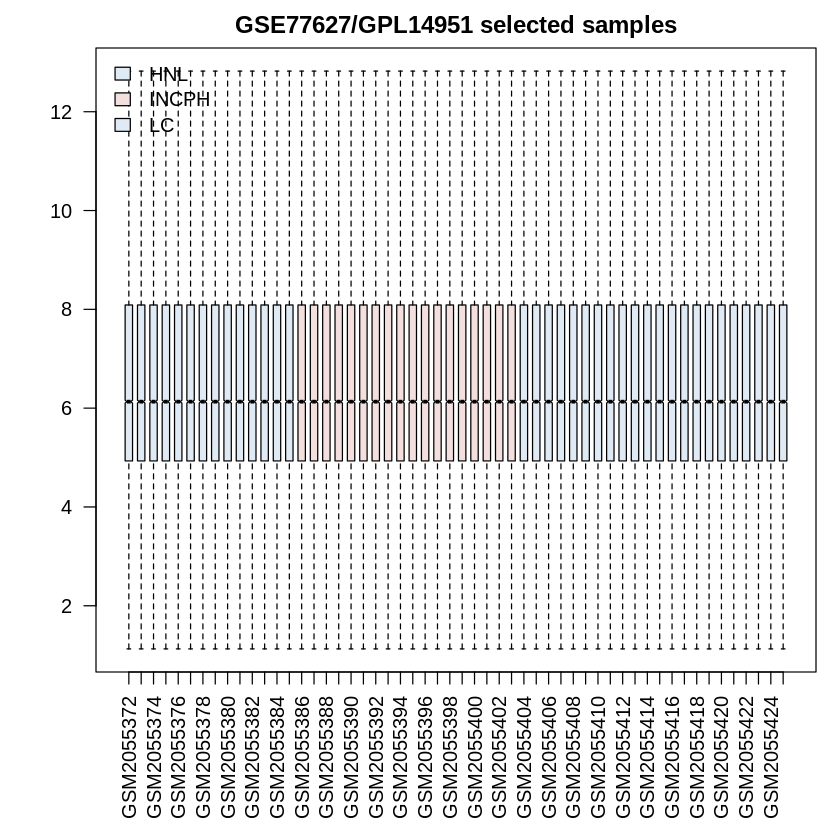

In [0]:
# boxplot(ex, boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=fl)
# legend("topleft", labels, fill=palette(), bty="n")
# set parameters and draw the plot
palette(c("#dfeaf4","#f4dfdf","#dfeaf4", "#AABBCC"))
#dev.new(width=4+dim(gset)[[2]]/5, height=6)
par(mar=c(2+round(max(nchar(sampleNames(gset)))/2),4,2,1))
title <- paste ("GSE77627", '/', annotation(gset), " selected samples", sep ='')
boxplot(ex, boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=fl)
legend("topleft", labels, fill=palette(), bty="n")
#dev.off()

In [0]:
library(ggplot2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



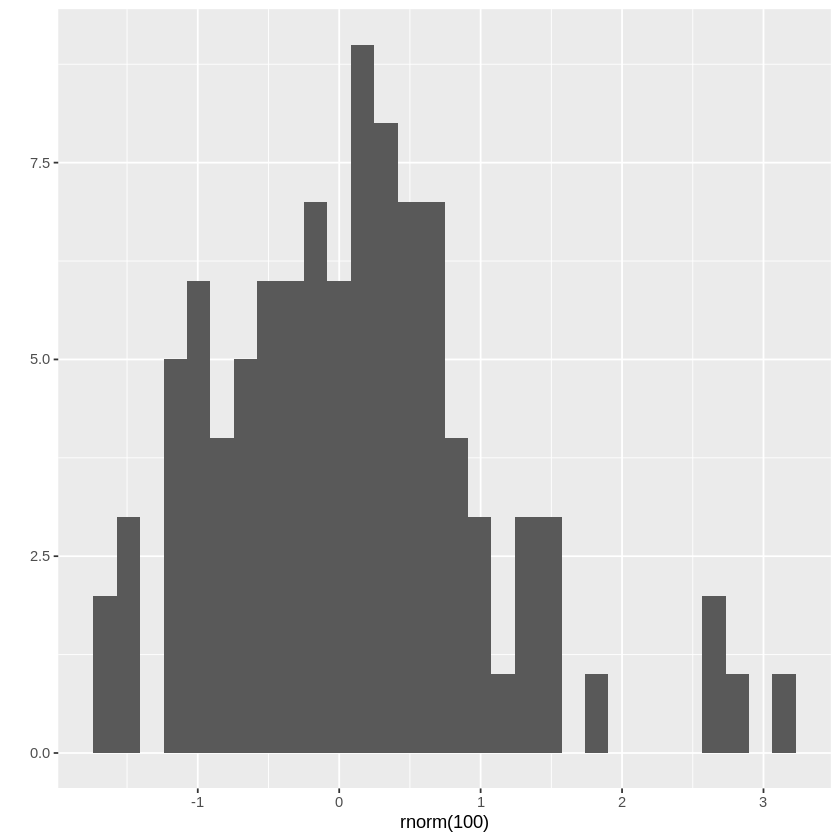

In [2]:
quickplot(rnorm(100))

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'ex' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(captu

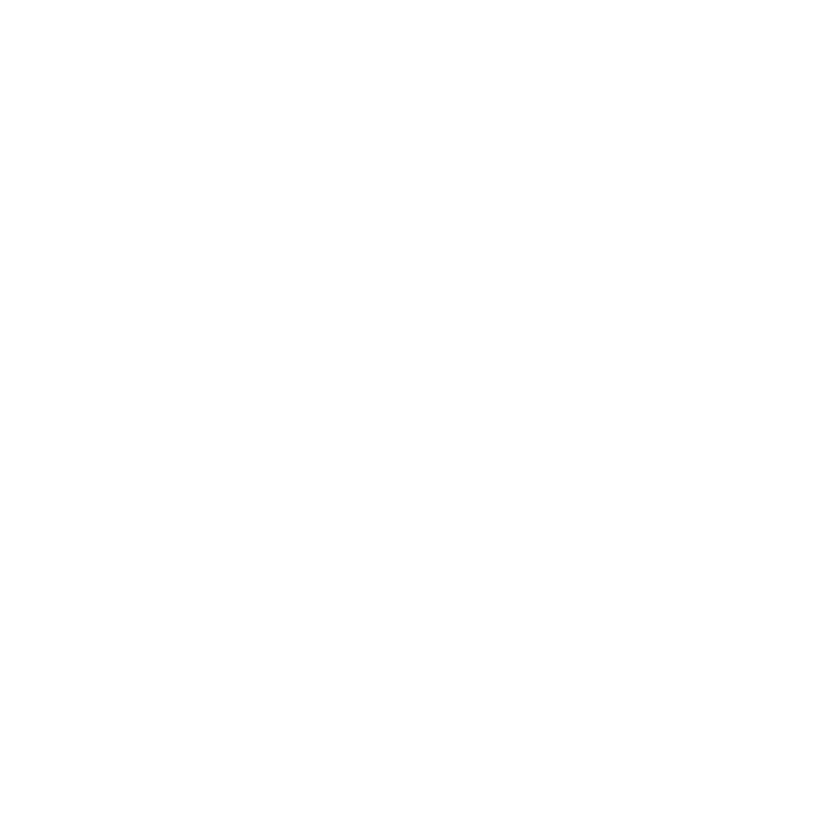

In [6]:
quickplot(ex,geom="boxplot")